# Simulate stochastic process

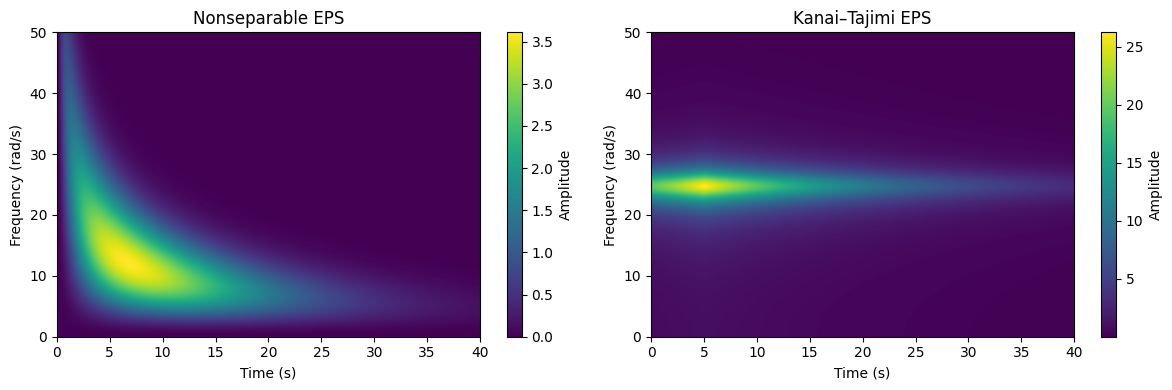

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

from eps.nonsep import nonseparable_evolutionary_power_spectrum
from eps.kt import kt_evolutionary_power_spectrum

time = np.linspace(0, 40, 512)
freq = np.linspace(0, 50, 512)

X, Y = np.meshgrid(time, freq)

eps_cp = np.zeros((len(time), len(freq)))
eps_kt = np.zeros((len(time), len(freq)))

#EPSs parameters
S0 = 1
b0 = 0.15

#KT parameter
omega_g = 25
zeta_g = 0.1

for i in range(len(time)):
    for j in range(len(freq)):
        eps_cp[i][j] = nonseparable_evolutionary_power_spectrum(freq[j], time[i], S0, b0)
        eps_kt[i][j] = kt_evolutionary_power_spectrum(freq[j], time[i], S0, omega_g, zeta_g, b0, 5)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

im0 = axes[0].imshow(
    eps_cp.T,                  # transpose so freq is y-axis
    extent=[time.min(), time.max(), freq.min(), freq.max()],
    origin='lower',
    aspect='auto',
    cmap=cm.viridis
)
axes[0].set_title("Nonseparable EPS")
axes[0].set_xlabel("Time (s)")
axes[0].set_ylabel("Frequency (rad/s)")
fig.colorbar(im0, ax=axes[0], label="Amplitude")

im1 = axes[1].imshow(
    eps_kt.T,                  # transpose so freq is y-axis
    extent=[time.min(), time.max(), freq.min(), freq.max()],
    origin='lower',
    aspect='auto',
    cmap=cm.viridis
)
axes[1].set_title("Kanai–Tajimi EPS")
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("Frequency (rad/s)")
fig.colorbar(im1, ax=axes[1], label="Amplitude")

plt.tight_layout()
plt.show()

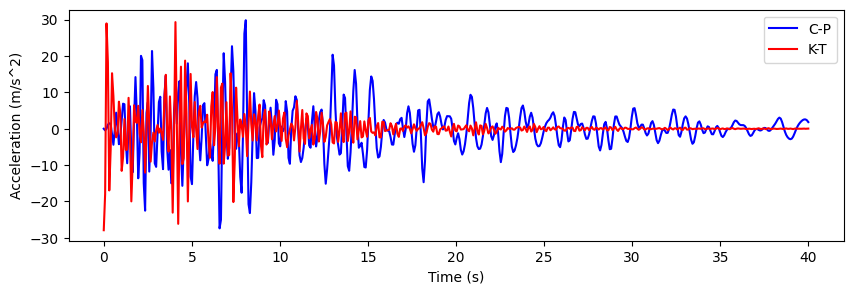

In [4]:
from simulate_process import simulate_process

w_cp = np.zeros((len(time), len(time)))
w_kt = np.zeros((len(time), len(time)))

for i in range(w_cp.shape[0]):
    w_cp[i,:] = simulate_process(time, S0, max(freq)/2, omega_g, zeta_g, b0)
    w_kt[i,:] = simulate_process(time, S0, omega_g, omega_g, zeta_g, b0, eps_type='kt')

fig = plt.figure(figsize=(10,3))

plt.plot(time, w_cp[10,:], 'b')
plt.plot(time, w_kt[10,:], 'r')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s^2)')
plt.legend(['C-P', 'K-T'])
plt.show()

In [5]:
import pandas as pd

w_cp_df = pd.DataFrame(w_cp.T).add_prefix('cp_')
w_kt_df = pd.DataFrame(w_kt.T).add_prefix('kt_')

df_results = pd.concat([w_cp_df, w_kt_df], axis=1)
df_results['time'] = time
df_results.to_csv(f'data/realizations/stochastic_process_{S0}_{b0}_{omega_g}_{zeta_g}.csv', index=False)

# GHW

In [8]:
import numpy as np
from tqdm import tqdm
from typing import List, Tuple, Dict, Union

def _next_pow2(n: int) -> int:
    return 1 << (n - 1).bit_length()

def ghw_transform(
    x: Union[np.ndarray, List[float]], fs: float, bands_hz: List[Tuple[float, float]], analytic: bool = True, nfft: 
    Union[int, None] = None, return_downsampled: bool = True) -> Dict[str, List[np.ndarray]]:
    """
    Generalized Harmonic Wavelet transform via frequency-domain masking.

    Parameters
    ----------
    x : array-like, shape (N,) or (M,N)
        Signal(s). If 2D, each row is a separate signal.
    fs : float
        Sampling rate (Hz).
    bands_hz : list of (flo, fhi)
        Non-overlapping frequency bands, in Hz. 0 <= flo < fhi <= fs/2.
    analytic : bool
        If True, keep only positive-frequency content and double non-DC/Nyquist bins
        to form an analytic band-limited signal (complex). If False, uses symmetric bands (real IFFT).
    nfft : int or None
        FFT length. Defaults to next power of 2 >= N.
    return_downsampled : bool
        If True, each band is critically downsampled (by floor(fs/(2*bandwidth)) or 1 minimum).
        If False, returns full-rate complex band signals.

    Returns
    -------
    out : dict
        {
          "complex": [c_band0, c_band1, ...],           # complex arrays per band
          "real":    [(c.real, c.imag) per band],       # tuple of arrays (Re, Im)
          "bands":   bands_hz,                          # echoed band edges (Hz)
          "fs_band": [effective_fs for each band],      # sample rate after any downsampling
          "reconstruct_fullrate": callable              # function() -> reconstructed signal at full rate
        }
    """
    x = np.asarray(x)
    if x.ndim == 1:
        x = x[None, :]   # shape to (M,N)
    M, N = x.shape
    if nfft is None:
        nfft = _next_pow2(N)

    # FFT frequency grid
    freqs = np.fft.rfftfreq(nfft, d=1.0/fs)  # non-negative freqs (length nfft//2+1)
    X = np.fft.rfft(x, n=nfft, axis=1)       # shape (M, n_rfft)

    # Prepare outputs
    complex_bands = []
    real_pairs = []
    fs_bands = []

    # Helper for reconstruction: accumulate masked spectra for sum of bands
    X_sum = np.zeros_like(X, dtype=np.complex128)

    for (flo, fhi) in tqdm(bands_hz):
        if flo < 0 or fhi > fs/2 + 1e-9 or fhi <= flo:
            raise ValueError(f"Bad band [{flo},{fhi}] for fs={fs}")

        # Build mask on rFFT bins
        band_mask = (freqs >= flo) & (freqs < fhi)
        mask = np.zeros_like(freqs, dtype=np.float64)
        mask[band_mask] = 1.0

        # For analytic: we keep only +freqs (rFFT already gives +freqs), and
        # double interior bins (except DC and Nyquist if present) to conserve energy
        if analytic:
            # Double all selected bins except DC (k=0) and Nyquist (if nfft even)
            dbl = mask.copy()
            if nfft % 2 == 0:
                nyq_bin = nfft // 2
            else:
                nyq_bin = None
            # DC
            if 0 < len(dbl):
                dbl[0] = 0.0
            # Nyquist
            if nyq_bin is not None and nyq_bin < len(dbl):
                dbl[nyq_bin] = 0.0
            # Apply: 1 + mask (so selected interior bins become 2, others 1)
            scale = 1.0 + dbl
            X_band = X * (mask * scale)
        else:
            # Symmetric (real) band: apply rectangle here then mirror after irfft
            X_band = X * mask

        # Accumulate for reconstruction (using same masked spectrum)
        X_sum += X_band

        # Inverse transform to time domain at full rate
        band_time_full = np.fft.irfft(X_band, n=nfft, axis=1)[:, :N]  # shape (M,N)
        # If analytic=True, band_time_full is complex? irfft returns real. We need complex analytic signal.
        # Correct approach: build full complex spectrum (one-sided) and use standard IFFT.
        # We'll rederive properly below.

        # -------- Correct analytic synthesis (complex) --------
        # Build full complex spectrum for analytic signal: positive freqs only -> IFFT of complex spectrum
        # Start from full FFT bins indexing (0..nfft-1). We'll place the masked positive rFFT bins and zeros elsewhere.
        # Create complex spectrum with zeros
        full_spec = np.zeros((M, nfft), dtype=np.complex128)
        # Map rFFT bins to full FFT: k=0..nfft//2 correspond to +freqs; negatives are k=nfft-kp
        # Copy selected bins
        Xp = X * mask  # selected +freq bins (no doubling yet)
        # Double interior bins for analytic (exclude DC and Nyquist)
        Xp_dbl = Xp.copy()
        Xp_dbl = Xp.copy()
        if analytic:
            # double interior bins
            interior = np.ones_like(freqs, dtype=bool)
            interior[0] = False
            if nfft % 2 == 0:
                nyq_bin = nfft // 2
                if nyq_bin < len(interior):
                    interior[nyq_bin] = False
            Xp_dbl[:, interior] *= 2.0

        # Place +freqs
        full_spec[:, 0:len(freqs)] = Xp_dbl
        # No negative freqs (analytic)
        # IFFT to complex time series
        band_time = np.fft.ifft(full_spec, axis=1)[:, :N]  # complex (M,N)

        # Optional critical downsampling by band width
        if return_downsampled:
            bw = max(fhi - flo, 1e-12)  # Hz
            # Nyquist for this bandlimited signal is bw; sample at >= 2*bw
            dec = int(max(1, np.floor(fs / (2.0 * bw))))
            band_time_ds = band_time[:, ::dec]
            complex_bands.append(band_time_ds.squeeze() if M == 1 else band_time_ds)
            fs_bands.append(fs / dec)
            real_pairs.append((band_time_ds.real.squeeze() if M == 1 else band_time_ds.real,
                               band_time_ds.imag.squeeze() if M == 1 else band_time_ds.imag))
        else:
            complex_bands.append(band_time.squeeze() if M == 1 else band_time)
            fs_bands.append(fs)
            real_pairs.append((band_time.real.squeeze() if M == 1 else band_time.real,
                               band_time.imag.squeeze() if M == 1 else band_time.imag))

    def reconstruct_fullrate() -> np.ndarray:
        """
        Perfect reconstruction (full-rate) using the same masks (sum of bands).
        Returns shape (N,) or (M,N), matching input shape.
        """
        x_rec = np.fft.irfft(X_sum, n=nfft, axis=1)[:, :N]
        return x_rec.squeeze() if M == 1 else x_rec

    return {
        "complex": complex_bands,
        "real": real_pairs,
        "bands": bands_hz,
        "fs_band": fs_bands,
        "reconstruct_fullrate": reconstruct_fullrate,
    }


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv(f'data/realizations/stochastic_process_{S0}_{b0}_{omega_g}_{zeta_g}.csv')

t = df["time"].values
x = df["cp_1"].values

dt = np.diff(t)
fs = 1.0 / np.median(dt)
print(f"Estimated fs = {fs:.3f} Hz")

Estimated fs = 12.775 Hz


100%|██████████| 4/4 [00:00<00:00, 4786.65it/s]

Band 0: 0-2 Hz, fs_band=4.16 Hz
  First 5 complex coeffs: [-0.04138231+0.03206983j -0.02714469-0.07447687j  0.0699189 -0.03575207j
  0.04999457+0.02070486j  0.02223059+0.03958005j]
  Re: [-0.04138231 -0.02714469  0.0699189   0.04999457  0.02223059]
  Im: [ 0.03206983 -0.07447687 -0.03575207  0.02070486  0.03958005]

Band 1: 2-5 Hz, fs_band=6.24 Hz
  First 5 complex coeffs: [ 0.04578992+0.00878638j -0.0440148 +0.01471075j  0.05231713-0.05833129j
 -0.06659329+0.06428387j  0.02976703-0.03934045j]
  Re: [ 0.04578992 -0.0440148   0.05231713 -0.06659329  0.02976703]
  Im: [ 0.00878638  0.01471075 -0.05833129  0.06428387 -0.03934045]

Band 2: 5-8 Hz, fs_band=6.24 Hz
  First 5 complex coeffs: [-0.01184689-0.0532029j   0.03328564-0.0290689j   0.05026553+0.04772825j
  0.04276119+0.04539738j  0.08339868-0.03124034j]
  Re: [-0.01184689  0.03328564  0.05026553  0.04276119  0.08339868]
  Im: [-0.0532029  -0.0290689   0.04772825  0.04539738 -0.03124034]

Band 3: 8-12.487500000000004 Hz, fs_band=12.49

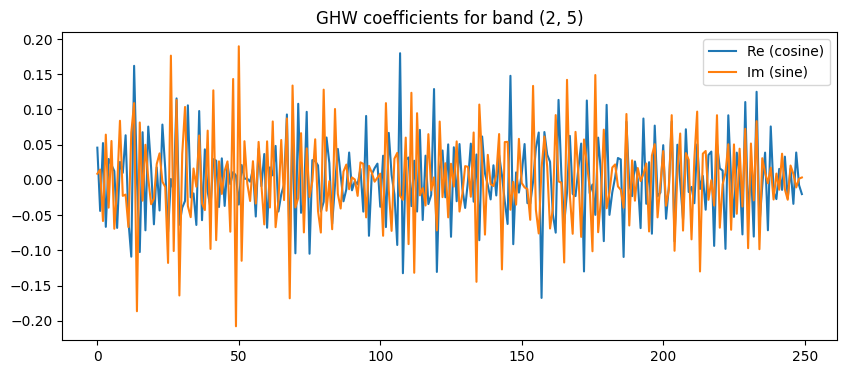

In [10]:
# ---- 3. Define bands up to Nyquist ----
bands = [(0, 2), (2, 5), (5, 8), (8, fs/2)]

# ---- 4. Run your GHW transform ----
out = ghw_transform(x, fs, bands, analytic=True, return_downsampled=True)

# ---- 5. Inspect coefficients ----
for i, (band, coeffs) in enumerate(zip(out["bands"], out["complex"])):
    print(f"Band {i}: {band[0]}-{band[1]} Hz, fs_band={out['fs_band'][i]:.2f} Hz")
    print("  First 5 complex coeffs:", coeffs[:5])
    print("  Re:", out["real"][i][0][:5])
    print("  Im:", out["real"][i][1][:5])
    print()

# ---- 6. Reconstruct original ----
x_rec = out["reconstruct_fullrate"]()
err = np.linalg.norm(x - x_rec) / np.linalg.norm(x)
print(f"Reconstruction error = {err:.2e}")

# ---- 7. Plot an example band ----
band_idx = 1  # choose band
c_band = out["complex"][band_idx]

plt.figure(figsize=(10,4))
plt.plot(c_band.real, label="Re (cosine)")
plt.plot(c_band.imag, label="Im (sine)")
plt.title(f"GHW coefficients for band {out['bands'][band_idx]}")
plt.legend()
plt.show()

In [29]:
1/dt[0]

np.float64(24.975000000000026)